## Calculating Distance Using the Haversine Formula

In [3]:
import pandas as pd

# Load the dataset
file_path = 'Datasets/Final_cleaned_dataset/bcn_final_cleaned_data_csv.csv'
df_bcn = pd.read_csv(file_path, delimiter = ';')

# Display the first few rows and the column names
df_bcn.head(), df_bcn.columns


(  neighbourhood_group_cleansed      id                          listing_url  \
 0                     Eixample  269467  https://www.airbnb.com/rooms/269467   
 1                 Ciutat Vella  270197  https://www.airbnb.com/rooms/270197   
 2                     Eixample   18674   https://www.airbnb.com/rooms/18674   
 3                     Eixample  272282  https://www.airbnb.com/rooms/272282   
 4                   Sant Martí   23197   https://www.airbnb.com/rooms/23197   
 
                                                 name  host_id       host_name  \
 0       Sunny and quiet Loft next to Sagrada Familia  1411775        Jeremies   
 1    *monthly stays* 4 Bedroom Apartment near Rambla  1414702          Ferran   
 2    Huge flat for 8 people close to Sagrada Familia    71615   Mireia  Maria   
 3             CHARMING; VERY SPACIOUS & BEST LOCATED  1425070             Mar   
 4  Forum CCIB DeLuxe; Spacious; Large Balcony; relax    90417  Etain (Marnie)   
 
    calculated_host_list

In [26]:
df_bcn["price"].sort_values()

17542       10.0
11972       10.0
9413        12.0
11976       13.0
5957        13.0
          ...   
16260     9059.0
13352     9999.0
12845    11999.0
12849    11999.0
486      13714.0
Name: price, Length: 18857, dtype: float64

In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Coordinates of Plaza Catalunya, Barcelona
city_center_bcn = (41.3874, 2.1686)

# Apply the Haversine function
df_bcn['distance_from_city_center'] = df_bcn.apply(
    lambda row: haversine(row['longitude'], row['latitude'], city_center_bcn[1], city_center_bcn[0]), axis=1
)


In [6]:
df_bcn.head(1)

,neighbourhood_group_cleansed,id,listing_url,name,host_id,host_name,calculated_host_listings_count,host_is_superhost,latitude,longitude,...,elevator,air conditioning,long_term,short_term,possible_long_term,number_of_reviews,review_scores_rating,room_type_encoded,bedrooms_encoded,distance_from_city_center
0,Eixample,269467,https://www.airbnb.com/rooms/269467,Sunny and quiet Loft next to Sagrada Familia,1411775,Jeremies,3,f,41.40181,2.1761,...,0,1,0,0,1,90,4.74,2,0,1.720122


#### Check Data for Outliers or Errors
Sometimes, input data errors (like incorrect sign or misplaced decimal points in latitude or longitude) can cause calculation errors:

In [7]:
# Check min and max values to spot obvious errors
print(df_bcn['latitude'].min(), df_bcn['latitude'].max())
print(df_bcn['longitude'].min(), df_bcn['longitude'].max())

41.35067283884408 41.458092
2.0855932 2.22771


#### Validate Coordinates
Make sure that the coordinates used for the city center and each Airbnb listing are correct and consistent in terms of formatting and precision:

In [8]:
# Coordinates for Plaza Catalunya, which should be correct
city_center_bcn = (41.3874, 2.1686)

# Ensure there are no negative or unrealistic coordinates in your data
df_bcn[['latitude', 'longitude']].describe()


,latitude,longitude
count,18857.000000,18857.000000
mean,41.392134,2.167034
std,0.014227,0.017616
min,41.350673,2.085593
25%,41.380970,2.156550
50%,41.389747,2.167990
75%,41.401658,2.177690
max,41.458092,2.227710


In [9]:
df_bcn['distance_from_city_center'].sort_values()

13903    0.002503
9058     0.030223
7286     0.042043
2188     0.049197
3399     0.052735
           ...   
5100     7.877450
14273    7.887209
5162     7.896295
13670    7.958310
9663     7.961416
Name: distance_from_city_center, Length: 18857, dtype: float64

In [10]:
# Categorize distances
# Calculate the minimum and maximum distance to define bins dynamically
min_distance = df_bcn['distance_from_city_center'].min()
max_distance = df_bcn['distance_from_city_center'].max()

# Define bins dynamically, ensuring the max bin exceeds the maximum distance in your data
bins = [min_distance, 1, 2, 3, 5, 8, max_distance + 0.1]  # Use max_distance + a small buffer (e.g., 0.1) to include all data
labels = ['<1 km', '1-2 km', '2-3 km', '3-5 km', '5-8 km', '>8 km']

# Categorize distances using pd.cut
df_bcn['distance_category'] = pd.cut(df_bcn['distance_from_city_center'], bins=bins, labels=labels, include_lowest=True)

# Check the distribution of the distance categories
print(df_bcn['distance_category'].value_counts())

# Optional: Display some rows to verify categorization
print(df_bcn[['distance_from_city_center', 'distance_category']].head())

distance_category
1-2 km    7399
<1 km     4606
2-3 km    3722
3-5 km    2734
5-8 km     396
>8 km        0
Name: count, dtype: int64
   distance_from_city_center distance_category
0                   1.720122            1-2 km
1                   0.992259             <1 km
2                   2.046952            2-3 km
3                   0.984913             <1 km
4                   5.094048            5-8 km


from sklearn.preprocessing import StandardScaler

# Normalize 'price' and 'distance_from_city_center'
scaler = StandardScaler()
df_bcn[['price_normalized', 'distance_from_city_center_normalized']] = scaler.fit_transform(df_bcn[['price', 'distance_from_city_center']])


/var/folders/t3/2pbngt7x2rxdwml4ql51pbt80000gn/T/ipykernel_26086/3214489048.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_bcn.groupby(['neighbourhood_group_cleansed', 'distance_category']).agg({


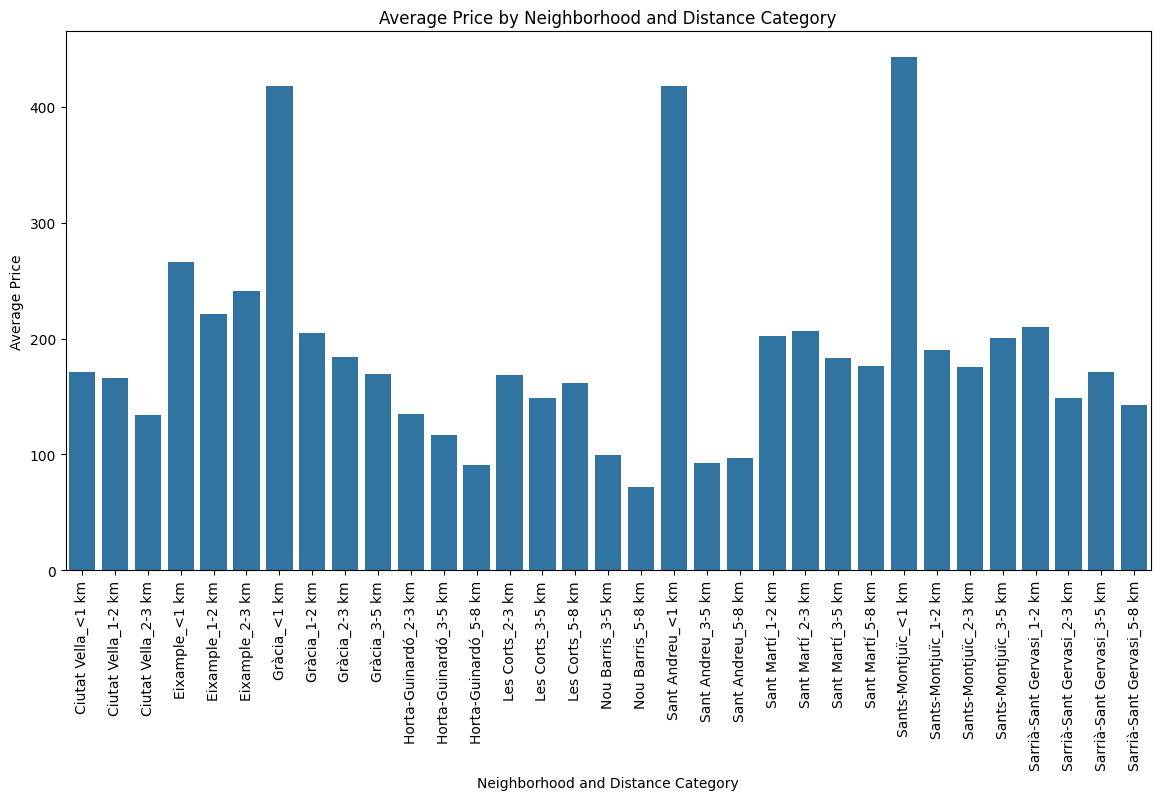

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the order for the distance categories
distance_order = pd.CategoricalDtype(categories=['<1 km', '1-2 km', '2-3 km', '3-5 km', '5-8 km', '>8 km'], ordered=True)
df_bcn['distance_category'] = df_bcn['distance_category'].astype(distance_order)

# Grouped analysis
grouped_data = df_bcn.groupby(['neighbourhood_group_cleansed', 'distance_category']).agg({
    'price': ['mean', 'median', 'count'],
    'review_scores_rating': ['mean', 'std']
}).reset_index()

# Sort the grouped_data by neighborhood and distance category
grouped_data = grouped_data.sort_values(by=['neighbourhood_group_cleansed', 'distance_category'])

# Create the interaction term for plotting purposes
grouped_data['neighborhood_distance_interaction'] = grouped_data['neighbourhood_group_cleansed'].astype(str) + '_' + grouped_data['distance_category'].astype(str)

# Filter out rows where the mean price is NaN or zero
grouped_data_filtered = grouped_data[grouped_data[('price', 'mean')].notna() & (grouped_data[('price', 'mean')] > 0)]

# Visualization with filtered data
plt.figure(figsize=(14, 7))
sns.barplot(x='neighborhood_distance_interaction', y=('price', 'mean'), data=grouped_data_filtered)
plt.title('Average Price by Neighborhood and Distance Category')
plt.xlabel('Neighborhood and Distance Category')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()



In [13]:
# # Grouped analysis by the normalized data
# grouped_data = df_bcn.groupby(['neighborhood_distance_interaction']).agg({
#     'price_normalized': ['mean', 'median', 'count'],
#     'review_scores_rating': ['mean', 'std']
# }).reset_index()

# # Visualization
# plt.figure(figsize=(14, 7))
# sns.barplot(x='neighborhood_distance_interaction', y=('price', 'mean'), data=grouped_data)
# plt.title('Average Price by Neighborhood and Distance Category')
# plt.xlabel('Neighborhood and Distance Category')
# plt.ylabel('Average Price')
# plt.xticks(rotation=90)
# plt.show()

## Price Categorization Using Percentiles

In [14]:
# Calculate percentiles
low_cost_threshold = df_bcn['price_normalized'].quantile(0.33)  # Change quantile values as per requirement
economic_threshold = df_bcn['price_normalized'].quantile(0.66)

# Categorize price_normalized
#s into 'Luxury', 'Economic', and 'Low-Cost'
df_bcn['price_category'] = pd.cut(df_bcn['price_normalized'], bins=[df_bcn['price_normalized'].min(), low_cost_threshold, economic_threshold, df_bcn['price_normalized'].max()],
                              labels=['Low-Cost', 'Economic', 'Luxury'], include_lowest=True)

# Display the distribution of price_normalized
# categories
print(df_bcn['price_category'].value_counts())

# Optionally, view some rows to confirm the categorization
print(df_bcn[['price_normalized', 'price_category']].head())


price_category
Luxury      6349
Economic    6276
Low-Cost    6232
Name: count, dtype: int64
   price_normalized price_category
0         -0.067063       Economic
1         -0.413151       Low-Cost
2          0.207772         Luxury
3          0.146697         Luxury
4          0.180628         Luxury


#### - Percentiles: The quantile function is used to determine the thresholds for each category. In this example, 33% of listings fall into 'Low-Cost', the next 33% into 'Economic', and the remaining 34% into 'Luxury'.
#### - Categorization: pd.cut is used to segment the price into categories based on these thresholds. The bins parameter specifies the edges of the bins, and labels assigns names to these bins.
#### - Visualization: The code prints the count of listings in each category to help you verify the distribution.

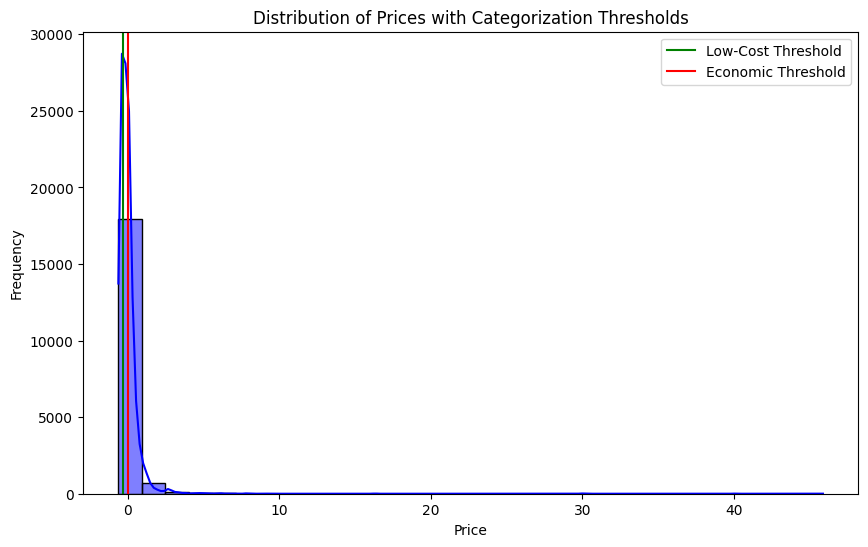

In [22]:
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(df_bcn['price_normalized'], bins=30, kde=True, color='blue')
plt.axvline(x=low_cost_threshold, color='green', label='Low-Cost Threshold')
plt.axvline(x=economic_threshold, color='red', label='Economic Threshold')
plt.title('Distribution of Prices with Categorization Thresholds')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## The visual is not very representative - due to a large number of observations fall into a small price range, and a few outliers extend the scale of the plot. 

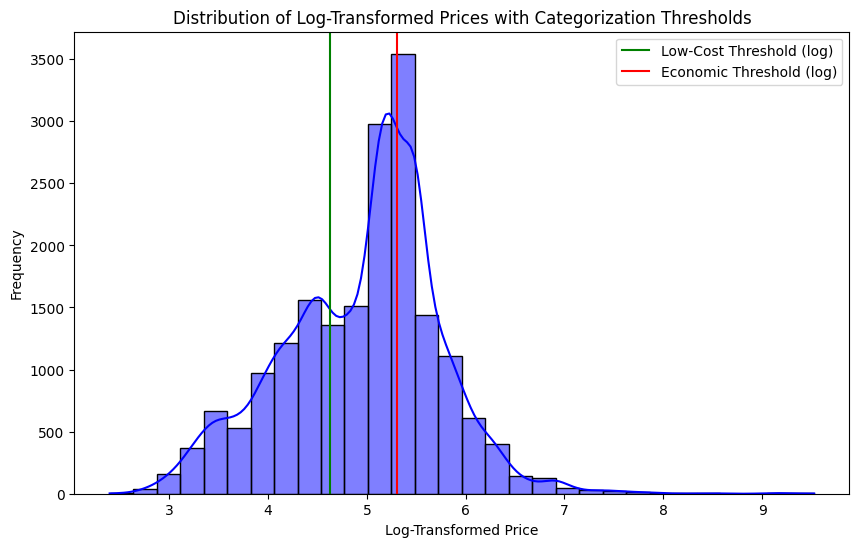

In [16]:
import numpy as np

# Assuming 'df_bcn' is your DataFrame and 'price_normalized' is the column you are analyzing
df_bcn['log_price'] = np.log1p(df_bcn['price_normalized'])  # Apply log transformation to price_normalized

# Plotting the histogram with log prices
plt.figure(figsize=(10, 6))
sns.histplot(df_bcn['log_price'], bins=30, kde=True, color='blue')

# Calculate new thresholds on log-transformed prices
log_low_cost_threshold = np.log1p(df_bcn['price_normalized']).quantile(0.33)
log_economic_threshold = np.log1p(df_bcn['price_normalized']).quantile(0.66)

# Adding vertical lines for new thresholds
plt.axvline(x=log_low_cost_threshold, color='green', label='Low-Cost Threshold (log)')
plt.axvline(x=log_economic_threshold, color='red', label='Economic Threshold (log)')

plt.title('Distribution of Log-Transformed Prices with Categorization Thresholds')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Observations:

#### 1. Center of Data Density:

If most listings are concentrated just below the economic threshold, this suggests that the majority of properties are priced at the upper end of the 'Economic' category.
This positioning implies that many properties are close to crossing into the 'Luxury' category, indicating a market where mid-range offerings dominate but with a substantial fraction nearing premium pricing.
Market Positioning:

#### 2. Competitive Pricing: 

The concentration near the economic threshold may suggest that setting prices slightly above this range could position listings as 'affordable luxury', potentially attracting customers looking for slightly higher-end accommodations without moving fully into the luxury price segment.

Marketing Focus: Promotional efforts might focus on the value provided by listings in the upper economic range, highlighting features or amenities that justify nearing the luxury category.
Strategic Insights:

#### 3. Inventory Assessment: 

Evaluate whether there is room to increase amenities or make other improvements that could justify moving these near-luxury listings fully into the luxury category to capture higher per-night rates.

#### 4. Customer Insights: 

Surveys or data analysis could help understand what features or factors would convince customers in the economic range to opt for slightly more expensive listings, potentially informing service improvements or new offerings.

#### 5. Pricing Strategy Adjustments:

Given that many listings are close to the economic threshold, consider experimenting with slight price adjustments to see if there is increased revenue potential without significantly impacting occupancy rates.
Further Statistical Analysis:

#### 6. Elasticity of Demand: 

Analyzing how changes in prices affect booking rates (price elasticity of demand) for listings near this threshold could provide actionable insights into how price-sensitive your customers are in this segment.
Segment-Specific Promotion: Tailoring promotions and discounts to capture the dense cluster of listings just below the economic threshold could optimize both occupancy and nightly rates.

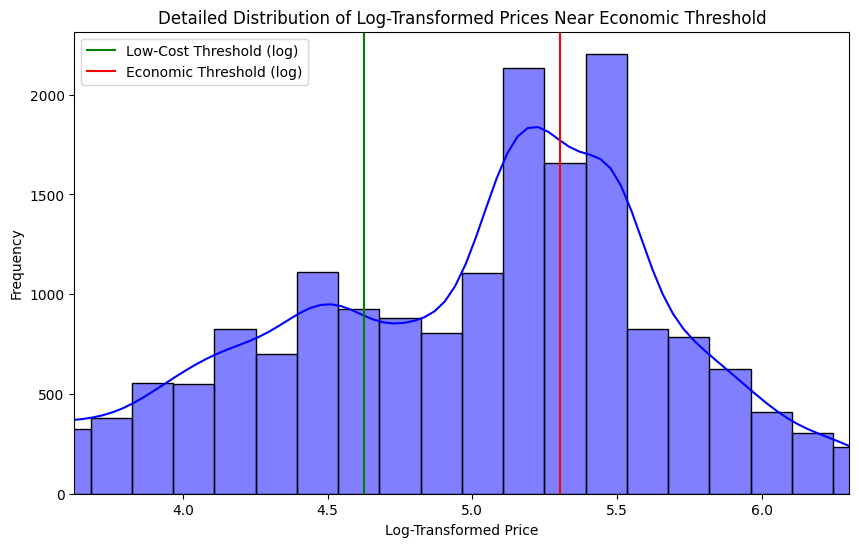

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Focusing on the dense region near the economic threshold
plt.figure(figsize=(10, 6))
sns.histplot(df_bcn['log_price'], bins=50, kde=True, color='blue')
plt.axvline(x=log_low_cost_threshold, color='green', label='Low-Cost Threshold (log)')
plt.axvline(x=log_economic_threshold, color='red', label='Economic Threshold (log)')

# Zooming into the region of interest
plt.xlim([log_low_cost_threshold - 1, log_economic_threshold + 1])  # Adjust the limits as needed to focus on the region of interest

plt.title('Detailed Distribution of Log-Transformed Prices Near Economic Threshold')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [28]:
# Collect necessary columns and export into a new csv file
feature_data_bcn = df_bcn[df_bcn['long_term'] != 1][["id", "neighbourhood_group_cleansed", "name", "host_id", "host_name", "host_is_superhost", 
                                  "calculated_host_listings_count", "latitude", "longitude", "kitchen", 
                                 "patio or balcony", "elevator", "air conditioning", "number_of_reviews", "review_scores_rating", "room_type_encoded",
                                   "bedrooms_encoded", "price", "price_category", "distance_from_city_center", "distance_category"]]

# Save to CSV or another format for use in visualization tools
feature_data_bcn.to_csv("Datasets/Final_cleaned_dataset/labled_features_bcn.csv", index=False)

In [24]:
feature_data_bcn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14854 entries, 0 to 18856
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   neighbourhood_group_cleansed  14854 non-null  object  
 1   host_is_superhost             14854 non-null  object  
 2   latitude                      14854 non-null  float64 
 3   longitude                     14854 non-null  float64 
 4   kitchen                       14854 non-null  int64   
 5   patio or balcony              14854 non-null  int64   
 6   elevator                      14854 non-null  int64   
 7   air conditioning              14854 non-null  int64   
 8   review_scores_rating          14854 non-null  float64 
 9   room_type_encoded             14854 non-null  int64   
 10  bedrooms_encoded              14854 non-null  int64   
 11  price                         14854 non-null  float64 
 12  price_category                14854 non-null  categ